In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os

10.1 Least squares fit
---
Correlation coefficients measure the strength and sign of a relationship, but
not the slope. There are several ways to estimate the slope; the most common
is a linear least squares fit.

 A linear fit" is a line intended to model the
relationship between variables. A \least squares" fit is one that minimizes
the mean squared error (MSE) between the line and the data

Explained Variance:
https://assessingpsyche.wordpress.com/2014/07/10/two-visualizations-for-explaining-variance-explained/

In [3]:
def pearson_coeff(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

def leastSquares(xs,ys):
    r = pearson_coeff(xs,ys)
    slope = r*(np.std(ys)/np.std(xs))
    intercept = np.mean(ys)-slope*np.mean(xs)
    return slope,intercept

def fitLine(xs,slope,intercept):
    fit_xs = np.sort(xs)
    fit_ys = fit_xs*slope+intercept
    return fit_xs,fit_ys

In [4]:
# import the data
os.chdir(os.path.join('..','data'))
df = pd.read_csv(r'2002FemPreg.csv',low_memory=False)
df = df[['caseid','prglngth','outcome','pregordr','birthord','totalwgt_lb','agepreg','finalwgt']]
df = df[df['outcome']==1] # live births
df = df.dropna(subset=['agepreg','totalwgt_lb'])

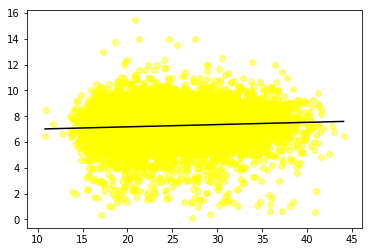

In [5]:
age_preg = df['agepreg']
total_wgt = df['totalwgt_lb']
slope,intercept = leastSquares(age_preg,total_wgt)

fit_xs,fit_ys = fitLine(age_preg,slope,intercept)
plt.plot(fit_xs,fit_ys,color='black')
plt.scatter(age_preg,total_wgt,alpha=0.5,color='yellow')

In [6]:
print('slope is %.3f and intercept is %.3f' %(slope,intercept))

slope is 0.017 and intercept is 6.830


10.3 Residuals
-----


In [7]:
def residuals(xs,ys,slope,intercept):
    return ys-(xs*slope+intercept)

def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

def percentile(p,series):
    series, cdfs = compute_cdf(series)
    if p < min(cdfs):
        p = min(cdfs)
    return series[cdfs.index(max([cdf for cdf in cdfs if cdf <=p]))]

Text(0,0.5,'residual')

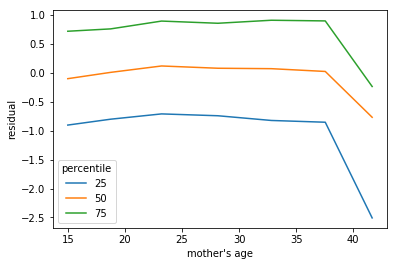

In [8]:
df['residual'] = pd.Series(residuals(age_preg,total_wgt,slope,intercept))

bins = np.arange(start=min(age_preg),stop=max(age_preg),step=5)
indices = np.digitize(age_preg,bins)
groups = df.groupby(indices)

for p in [0.25,0.50,0.75]:
    xs = []
    ys = [] 
    for i,group in groups:
        res = group['residual']
        age = group['agepreg']
        xs.append(np.mean(age))
        ys.append(percentile(p,res))

    plt.plot(xs,ys,label=int(p*100))
    plt.legend(title='percentile')
plt.xlabel('mother\'s age')
plt.ylabel('residual')

The lines are flat over most of the range, 
indicating that the relationship is linear.

The lines are mostly parallel, indicating 
that the variance of the residuals is the 
same over the range.

10.4 Estimation
-----

The parameters slope and inter are estimates based on a sample; like
other estimates, they are vulnerable to sampling bias, measurement error,
and sampling error.

sampling error is the result of measuring
a sample rather than the entire population

If we run this experiment again, how much
variability do we expect in the estimates?

In [9]:
slopes = []
intercepts = []
iters = 101
for _ in range(iters):
    resample_indices = np.random.choice(df.index,len(df),replace=True)
    resample_df = df.loc[resample_indices]
    sample_age = resample_df['agepreg']
    sample_wgt = resample_df['totalwgt_lb']
    slope,intercept=leastSquares(sample_age,sample_wgt)
    slopes.append(slope)
    intercepts.append(intercept)

mean_slopes = np.mean(slopes)
stderr_slopes = np.std(slopes)
mean_intercept = np.mean(intercepts)
stderr_intercept = np.std(intercepts)

In [10]:
def plot_CI(values,CI,xlabel='Slopes'):
    U_CI = CI+(1-CI)/2
    L_CI = (1-CI)/2
    
    x1,y1 = compute_cdf(values)
    low = percentile(L_CI,x1)
    high = percentile(U_CI,x1)

    fig = plt.figure()
    fig.set_size_inches(15,2.5)

    ax1 = plt.subplot(121)
    ax1.plot(x1,y1)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('CDF')
    ax1.plot([low,low],[0,1],[high,high],[0,1])
    val_50 = percentile(0.5,values)
    ax1.plot([val_50,val_50],[0,1])


    ax2 = plt.subplot(122)
    ax2.hist(values)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('Frequency')
    
    return [low,high]

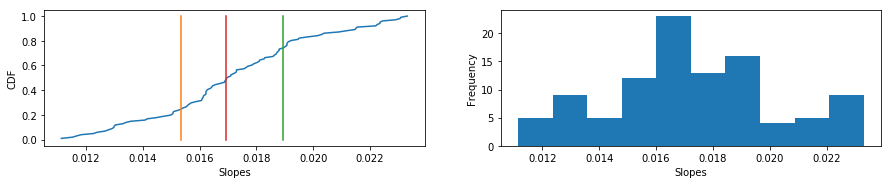

In [11]:
slope_lims = plot_CI(slopes,0.50)

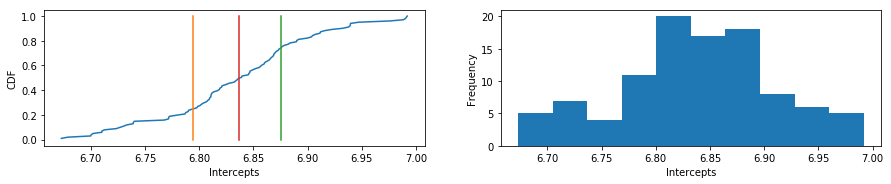

In [12]:
inter_lims = plot_CI(intercepts,0.50,xlabel='Intercepts')

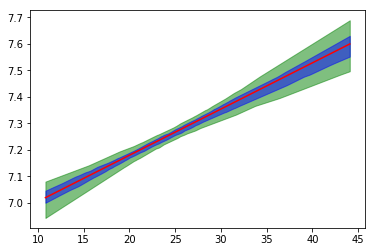

In [13]:
def compute_CI(values,CI):
    U_CI = CI+(1-CI)/2
    L_CI = (1-CI)/2
    
    x1,y1 = compute_cdf(values)
    low = percentile(L_CI,x1)
    high = percentile(U_CI,x1)
    return low,high

def plot_CI(CI,color):
    lims=np.zeros((iters,len(age_preg)))
    index =0
    for s,i in zip(slopes,intercepts):
        fit_xs_1,fit_ys_1 = fitLine(age_preg,s,i)
        lims[index] = fit_ys_1
        index +=1

    rows,cols = lims.shape

    lows = []
    highs = []
    for col in range(cols):
        low,high = compute_CI(lims[:,col],CI)
        lows.append(low)
        highs.append(high)

    plt.fill_between(fit_xs,lows,highs,alpha=0.5,color=color)

plt.plot(fit_xs,fit_ys,color='red')
plot_CI(0.9,color='green')
plot_CI(0.5,color='blue')

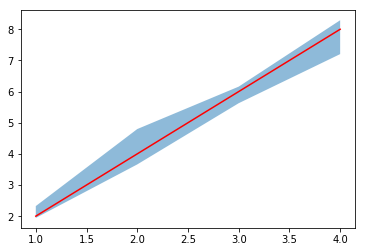

In [14]:
# fill between example
x=[1,2,3,4]
y=[2,4,6,8]
slope,intercept=leastSquares(x,y)
fit_xs,fit_ys=fitLine(x,slope,intercept)
plt.plot(x,y,color='red')
ys_low = [y+np.random.rand(1)[0]for y in fit_ys]
ys_high = [y-np.random.rand(1)[0] for y in fit_ys]
plt.fill_between(fit_xs,ys_low,ys_high,alpha=0.5)

10.5 Goodness of fit (Explained Variance)
----

if you use a linear model to make predictions, 

Std(res) is the root mean
squared error (RMSE) of your predictions. 
For example, if you use mother’s
age to guess birth weight, the RMSE of your guess would be 1.40 lbs.

If you guess birth weight without knowing the mother’s age, the RMSE of
your guess is Std(ys), which is 1.41 lbs. 

**So in this example, knowing a
mother’s age does not improve the predictions substantially.**

In [15]:
# standard deviation of residuals
slope,intercept = leastSquares(age_preg,total_wgt)
np.std(residuals(age_preg,total_wgt,slope,intercept)),np.std(total_wgt)

(1.4048754287857828, 1.4082155338406195)

There are several ways to measure the quality of a linear model, or goodness
of fit. One of the simplest is the standard deviation of the residuals

Another way to measure goodness of fit is the coefficient of determination, usually denoted R2 and called R-squared.

In [16]:
def r_squared(ys,res):
    return 1-np.var(res)/np.var(ys)

r_squared(total_wgt,df['residual'])

0.00473811547471048

In [17]:
# another way to determine the R2
np.square(pearson_coeff(age_preg,total_wgt))

0.004738115474710374

this indicates only 0.5% of the variance in child's weight is explained by the mother's age

In [18]:
np.std(total_wgt)

1.4082155338406195

10.6 Testing a linear model
-----

In [19]:
class SlopeTest:
    def __init__(self,xs,ys):
        self.xs= xs
        self.ys=ys
    
    def testStatistic(self,data1,data2):
        slope, intercept = leastSquares(data1,data2)
        return slope
    
    def makeModel(self):
        y_mean = np.mean(self.ys)
        self.res = np.mean(self.ys)-self.ys
        return y_mean+np.random.permutation(self.res)
    
    def p_value(self):
        self.slopes = []
        iters = 1000
        for _ in range(iters):
            null_hypo = self.makeModel()
            slope = self.testStatistic(self.xs,null_hypo)
            self.slopes.append(slope)
        return len([x for x in self.slopes if x > self.testStatistic(self.xs,self.ys)])/iters
        

The self parameter is a reference to the class instance itself, and is used to access variables that belongs to the class

In [20]:
s1 = SlopeTest(age_preg,total_wgt)
s1.p_value()

0.0

this is showing that the slope is significant and there is a relation between the mother's age and baby's birth weight

0.00018265364973635436

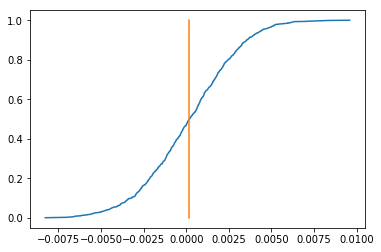

In [21]:
def compute_percent(series,p):
    x,y = compute_cdf(series)
    plt.plot(x,y)
    value= percentile(p,x)
    plt.plot([value,value],[0,1])
    return value
compute_percent(s1.slopes,0.5)

0.011137139585613402

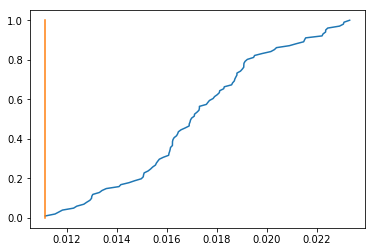

In [22]:
compute_percent(slopes,0)

10.7 Weighted Sampling
----

if you survey 100,000 people in a country of 300 million, each
respondent represents 3,000 people. If you oversample one group by a factor
of 2, each person in the oversampled group would have a lower weight, about
1500.

To correct for oversampling, we can use resampling; that is, we can draw
samples from the survey using probabilities proportional to sampling weights.

Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented).

Oversampling and undersampling are opposite and roughly equivalent techniques. They both involve using a bias to select more samples from one class than from another.

The usual reason for oversampling is to correct for a bias in the original dataset. One scenario where it is useful is when training a classifier using labelled training data from a biased source, since labelled training data is valuable but often comes from un-representative sources.

In [23]:
df.head()

,caseid,prglngth,outcome,pregordr,birthord,totalwgt_lb,agepreg,finalwgt,residual
0,1,39,1,1,1.0,8.8125,33.16,6448.271112,1.403333
1,1,39,1,2,2.0,7.8750,39.25,6448.271112,0.359539
2,2,39,1,1,1.0,9.1250,14.33,12999.542260,2.044489
3,2,39,1,2,2.0,7.0000,17.83,12999.542260,-0.141599
4,2,39,1,3,3.0,6.1875,18.33,12999.542260,-0.962826


In [24]:
def calc_pmf(series):
    pmf = series/sum(series)
    return series.index,pmf

Text(0,0.5,'Probability')

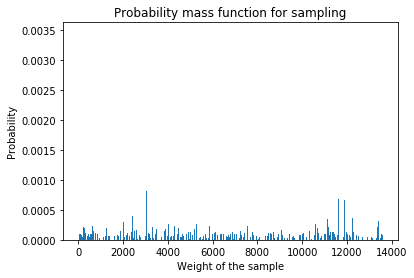

In [25]:
index,prob = calc_pmf(df['finalwgt'])
plt.bar(index,prob)
plt.title('Probability mass function for sampling')
plt.xlabel('Weight of the sample')
plt.ylabel('Probability')

In [26]:
df['sampling_prob_wgt'] = prob
df.head()

,caseid,prglngth,outcome,pregordr,birthord,totalwgt_lb,agepreg,finalwgt,residual,sampling_prob_wgt
0,1,39,1,1,1.0,8.8125,33.16,6448.271112,1.403333,0.000085
1,1,39,1,2,2.0,7.8750,39.25,6448.271112,0.359539,0.000085
2,2,39,1,1,1.0,9.1250,14.33,12999.542260,2.044489,0.000171
3,2,39,1,2,2.0,7.0000,17.83,12999.542260,-0.141599,0.000171
4,2,39,1,3,3.0,6.1875,18.33,12999.542260,-0.962826,0.000171


In [27]:
est_wgt = [np.random.choice(df['totalwgt_lb'],replace=True,p=prob,size=df['totalwgt_lb'].shape) for _ in range(1000)]
est = [np.random.choice(df['totalwgt_lb'],replace=True,size=df['totalwgt_lb'].shape) for _ in range(1000)]
est_mean_wgt = [np.mean(x) for x in est_wgt]
est_mean = [np.mean(x) for x in  est]

In [28]:
title = ['Weighted','Unweighted']
means =[np.mean(est_mean_wgt),np.mean(est_mean)]
std_errors = [np.std(est_mean_wgt),np.std(est_mean)]
CIs = [compute_CI(est_mean_wgt,0.9),compute_CI(est_mean,0.9)]
results= [means,std_errors,CIs]
pd.DataFrame(results,columns=title,index=['Mean','Std Error','90% CI'])

,Weighted,Unweighted
Mean,7.34828,7.26514
Std Error,0.0148167,0.0145961
90% CI,"(7.325279375968135, 7.372994578446559)","(7.240470789997787, 7.289430736888693)"


In this example, the effect of weighting is small but non-negligible. The difference in estimated means, with and without weighting, is about 0.08 pounds